In [1]:
import h5py
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import itertools 
import pyts
from pyts.approximation import PiecewiseAggregateApproximation

from sklearn.utils import class_weight

import pathlib
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, optimizers
from tensorflow.keras.layers import Convolution2D,Conv2D, Dense,Dropout, Flatten, Activation, MaxPooling2D, Input, Conv1D, GlobalAveragePooling1D, TimeDistributed, GRU, LSTM

print(tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
gpus = tf.config.experimental.list_physical_devices('GPU')

try:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
except RuntimeError as e:
    print(e)

2022-02-07 21:57:29.469999: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcudart.so.11.0


2.5.0
Num GPUs Available:  1


2022-02-07 21:57:30.590274: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcuda.so.1
2022-02-07 21:57:30.638369: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1734] Found device 0 with properties: 
pciBusID: 0000:21:00.0 name: NVIDIA GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.76GiB deviceMemoryBandwidth: 573.69GiB/s
2022-02-07 21:57:30.638418: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcudart.so.11.0
2022-02-07 21:57:30.642995: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcublas.so.11
2022-02-07 21:57:30.643065: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcublasLt.so.11
2022-02-07 21:57:30.644716: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library li

In [2]:
from os import environ
dataset = environ['dataset']
print(dataset)

eco_gen_GASF_60m_300S0X_2_R12_80-20


In [3]:
#my defs 
from modules.models import  LSTM_3D_V56, CNN_V56,LSTM_BI_V56
from modules.tools import my_print, plot_confusion_matrix_norm, get_data,get_data_split, evaluate_model, create_tl_model
from modules.HDF5ImageGenerator import HDF5ImageGenerator

In [4]:
#LOAD DATASET
#file_name = "ukdale_gen_GASF_13m_100S5X12A54480"
#file_name = "refit_gen_GASF_13m_100S5X_15A166006"
file_name = "refit_gen_GASF_13m_100S5X_15A166006_R42-80-20"
#file_name = "refit_gen_GASF_13m_100S5X_15A166006_R42_80-20"
file_name = "refit_gen_GASF_60m_300S0X_15A157030N_R12_80-20-V1"
file_name = environ["dataset"]
#read the file
path = str(pathlib.Path().resolve())

path_data = f"{path}""/data/"f"{file_name}""/"f"{file_name}"".hdf5"

file = h5py.File(path_data,"r+")

In [5]:
x_test,y_test,d_class_weights,num_of_classes,appliances = get_data(file)

['HEKA', 'fridge/freezer', 'HTPC', 'audio system', 'broadband router', 'coffee maker', 'computer', 'lamp', 'laptop computer', 'microwave', 'washing machine']
{0: 8.877756286266925, 1: 0.15678009523354078, 2: 0.6806762568589648, 3: 2.9301583248212464, 4: 3.202260517686458, 5: 4.176722176722177, 6: 1.1790182126435305, 7: 2.295129512951295, 8: 1.5334602920049447, 9: 8.934786840568425, 10: 10.103015628439357}
 
Tests 
HEKA test: 117 train: 470
fridge/freezer test: 6654 train: 26614
HTPC test: 1533 train: 6130
audio system test: 356 train: 1424
broadband router test: 326 train: 1303
coffee maker test: 249 train: 999
computer test: 885 train: 3539
lamp test: 455 train: 1818
laptop computer test: 680 train: 2721
microwave test: 117 train: 467
washing machine test: 103 train: 413


In [6]:
def select_model(learn_type):
    
    if learn_type == "CNN":
        model = CNN_V56(file["data/train/gaf"][0:10],num_of_classes,lr= 0.00002)

    if learn_type == "LSTM":
        model = LSTM_3D_V56(file["data/train/gaf"][0:10],num_of_classes,lr= 0.00002)

    if learn_type == "BI_LSTM":
        model = LSTM_BI_V56(file["data/train/gaf"][0:10],num_of_classes,lr= 0.00002)

    return model
              

In [7]:
path_save = path+'/experiment_automation/output/'+environ['learn_type']+'/'+dataset.split("_")[0]+"/"+environ['train_type']+"/"+dataset.split("_")[0]+"_"+environ['seed']+"_"+environ['tl_datasets']
path_save_nb = path_save+"_out.ipynb"
path_save_log = path_save+"_out_log2.txt"

In [8]:
from keras.callbacks import LambdaCallback
#path_log= path+'/experiment_automation/output/'+environ['learn_type']+'/'+dataset.split("_")[0]+"/"+environ['train_type']+"/"+dataset.split("_")[0]+"_"+environ['seed']+"_"+environ['tl_datasets']+"_log.txt"
txt_log = open(path_save+"_log.txt", mode='wt', buffering=1)
txt_log.write("file created! \n")

save_op_callback = LambdaCallback(
  on_epoch_end = lambda epoch, logs: txt_log.write(
    str({'epoch': epoch, 'loss': logs['loss'],'acc': logs['accuracy']}) + '\n'),
                                                           
)

In [9]:
print(path_save_nb)

/workspace/notebooks/experiment_automation/output/CNN/eco/TL/eco_12_refit, iawe, redd, ukdale_out.ipynb


In [10]:
# rm $path_save_log

In [11]:
# %%capture cap 

# with open(path_save_log,"wt") as f:
#     f.write(cap.stdout)
    
# print("out capture..")

In [12]:
# %%capture cap --no-stderr


if environ['train_type'] == "BB":

    #define generator
    train_gen = HDF5ImageGenerator(
        src= path_data,
        X_key="data/train/gaf",
        y_key="labels/train/gaf",
        classes_key="appliances/classes",
        labels_encoding="hot",
        shuffle=True,
        batch_size=int(environ['batch_size']),
        num_classes=num_of_classes,
        mode="train",
        )
    
    model = select_model(environ['learn_type'])
    
    txt_log.write("fitting BB model: \n")
    
    model.fit(
        train_gen,
        verbose=2,
        epochs=int(environ['epochs']),
        class_weight=d_class_weights,
        callbacks = [save_op_callback],
    )
    
    txt_log.write("finished fitting BB model: \n")

    evaluate_model(model,x_test,y_test,appliances)
    
    if environ['save_model']=="True":

        path_model_save = path+"/models/"+environ['learn_type']+"/"+dataset.split("_")[0]+"_"+dataset.split("_R")[1][0:2]
        model.save(path_model_save)
        txt_log.write("model saved to:"+"/models/"+environ['learn_type']+"/"+dataset.split("_")[0]+"_"+dataset.split("_R")[1][0:2]+" \n")
        
        
# with open(path_save+"_out_log.txt" as f:
#     f.write(cap.stdout)


In [13]:
#model = keras.models.load_model(path_model1)
# model_used = model

In [14]:
# evaluate_model(model,x_test,y_test,appliances)

using dataset data eco training on model refit seed 12
reading data, printing stats: 
['HEKA', 'fridge/freezer', 'HTPC', 'audio system', 'broadband router', 'coffee maker', 'computer', 'lamp', 'laptop computer', 'microwave', 'washing machine']
{0: 8.877756286266925, 1: 0.15678009523354078, 2: 0.6806762568589648, 3: 2.9301583248212464, 4: 3.202260517686458, 5: 4.176722176722177, 6: 1.1790182126435305, 7: 2.295129512951295, 8: 1.5334602920049447, 9: 8.934786840568425, 10: 10.103015628439357}
 
Tests 
HEKA test: 117 train: 470
fridge/freezer test: 6654 train: 26614
HTPC test: 1533 train: 6130
audio system test: 356 train: 1424
broadband router test: 326 train: 1303
coffee maker test: 249 train: 999
computer test: 885 train: 3539
lamp test: 455 train: 1818
laptop computer test: 680 train: 2721
microwave test: 117 train: 467
washing machine test: 103 train: 413
loading model
compling TL model..


2022-02-07 21:57:37.393704: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1734] Found device 0 with properties: 
pciBusID: 0000:21:00.0 name: NVIDIA GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.76GiB deviceMemoryBandwidth: 573.69GiB/s
2022-02-07 21:57:37.394180: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1872] Adding visible gpu devices: 0
2022-02-07 21:57:37.394513: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcudart.so.11.0
2022-02-07 21:57:38.223035: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1258] Device interconnect StreamExecutor with strength 1 edge matrix:
2022-02-07 21:57:38.223072: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1264]      0 
2022-02-07 21:57:38.223080: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1277] 0:   N 
2022-02-07 21:57:38.223671: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1418] Created TensorFlow device 

Normal way
[0 1 2 3 4 5 6 7 8 9]
Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(
2022-02-07 21:57:38.812712: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-02-07 21:57:38.832517: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 3299990000 Hz


Epoch 1/20


2022-02-07 21:57:39.330428: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcudnn.so.8
2022-02-07 21:57:40.031901: I tensorflow/stream_executor/cuda/cuda_dnn.cc:380] Loaded cuDNN version 8202
2022-02-07 21:57:40.852944: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcublas.so.11
2022-02-07 21:57:41.418351: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcublasLt.so.11


1435/1435 - 73s - loss: 1.1082 - accuracy: 0.5558
Epoch 2/20
1435/1435 - 70s - loss: 0.8188 - accuracy: 0.7022
Epoch 3/20
1435/1435 - 72s - loss: 0.7362 - accuracy: 0.7396
Epoch 4/20
1435/1435 - 72s - loss: 0.6928 - accuracy: 0.7540
Epoch 5/20
1435/1435 - 72s - loss: 0.7041 - accuracy: 0.7641
Epoch 6/20
1435/1435 - 72s - loss: 0.6247 - accuracy: 0.7716
Epoch 7/20
1435/1435 - 71s - loss: 0.6450 - accuracy: 0.7753
Epoch 8/20
1435/1435 - 71s - loss: 0.5934 - accuracy: 0.7832
Epoch 9/20
1435/1435 - 70s - loss: 0.5760 - accuracy: 0.7911
Epoch 10/20
1435/1435 - 70s - loss: 0.5698 - accuracy: 0.7913
Epoch 11/20
1435/1435 - 70s - loss: 0.5655 - accuracy: 0.7914
Epoch 12/20
1435/1435 - 70s - loss: 0.5590 - accuracy: 0.7957
Epoch 13/20
1435/1435 - 70s - loss: 0.5289 - accuracy: 0.8079
Epoch 14/20
1435/1435 - 70s - loss: 0.5370 - accuracy: 0.8033
Epoch 15/20
1435/1435 - 71s - loss: 0.5124 - accuracy: 0.8084
Epoch 16/20
1435/1435 - 71s - loss: 0.5323 - accuracy: 0.8064
Epoch 17/20
1435/1435 - 71s 

/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Normal way
[0 1 2 3 4 5 6 7 8 9]
Epoch 1/20
1435/1435 - 73s - loss: 2.0761 - accuracy: 0.3399
Epoch 2/20
1435/1435 - 71s - loss: 1.3924 - accuracy: 0.4895
Epoch 3/20
1435/1435 - 71s - loss: 1.3461 - accuracy: 0.5056
Epoch 4/20
1435/1435 - 71s - loss: 1.4164 - accuracy: 0.4522
Epoch 5/20
1435/1435 - 71s - loss: 1.3634 - accuracy: 0.5174
Epoch 6/20
1435/1435 - 71s - loss: 1.4116 - accuracy: 0.5019
Epoch 7/20
1435/1435 - 71s - loss: 1.2670 - accuracy: 0.5362
Epoch 8/20
1435/1435 - 70s - loss: 1.1702 - accuracy: 0.5834
Epoch 9/20
1435/1435 - 70s - loss: 1.1838 - accuracy: 0.5977
Epoch 10/20
1435/1435 - 70s - loss: 1.1544 - accuracy: 0.6072
Epoch 11/20
1435/1435 - 70s - loss: 1.1049 - accuracy: 0.6099
Epoch 12/20
1435/1435 - 70s - loss: 1.1124 - accuracy: 0.6204
Epoch 13/20
1435/1435 - 70s - loss: 1.1226 - accuracy: 0.6038
Epoch 14/20
1435/1435 - 70s - loss: 1.1120 - accuracy: 0.6180
Epoch 15/20
1435/1435 - 70s - loss: 1.0684 - accuracy: 0.6096
Epoch 16/20
1435/1435 - 70s - loss: 1.0375 - a

/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Normal way
[0 1 2 3 4 5 6 7 8 9]
Epoch 1/20
1435/1435 - 73s - loss: 2.2348 - accuracy: 0.1307
Epoch 2/20
1435/1435 - 71s - loss: 1.7005 - accuracy: 0.3795
Epoch 3/20
1435/1435 - 71s - loss: 1.4730 - accuracy: 0.4866
Epoch 4/20
1435/1435 - 71s - loss: 1.3988 - accuracy: 0.5010
Epoch 5/20
1435/1435 - 71s - loss: 1.3803 - accuracy: 0.5168
Epoch 6/20
1435/1435 - 71s - loss: 1.3004 - accuracy: 0.5807
Epoch 7/20
1435/1435 - 71s - loss: 1.2663 - accuracy: 0.6002
Epoch 8/20
1435/1435 - 71s - loss: 1.1965 - accuracy: 0.6288
Epoch 9/20
1435/1435 - 71s - loss: 1.1735 - accuracy: 0.6376
Epoch 10/20
1435/1435 - 71s - loss: 1.0854 - accuracy: 0.6585
Epoch 11/20
1435/1435 - 71s - loss: 1.0595 - accuracy: 0.6920
Epoch 12/20
1435/1435 - 71s - loss: 1.0271 - accuracy: 0.6991
Epoch 13/20
1435/1435 - 70s - loss: 1.0657 - accuracy: 0.6833
Epoch 14/20
1435/1435 - 71s - loss: 1.0398 - accuracy: 0.7051
Epoch 15/20
1435/1435 - 71s - loss: 1.0337 - accuracy: 0.6965
Epoch 16/20
1435/1435 - 71s - loss: 0.9996 - a

/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Normal way
[0 1 2 3 4 5 6 7 8 9]
Epoch 1/20
1435/1435 - 73s - loss: 2.0054 - accuracy: 0.2682
Epoch 2/20
1435/1435 - 71s - loss: 1.2469 - accuracy: 0.6586
Epoch 3/20
1435/1435 - 71s - loss: 1.0686 - accuracy: 0.7076
Epoch 4/20
1435/1435 - 71s - loss: 0.9797 - accuracy: 0.7291
Epoch 5/20
1435/1435 - 71s - loss: 0.9423 - accuracy: 0.7276
Epoch 6/20
1435/1435 - 71s - loss: 0.8769 - accuracy: 0.7453
Epoch 7/20
1435/1435 - 70s - loss: 0.8410 - accuracy: 0.7581
Epoch 8/20
1435/1435 - 70s - loss: 0.8101 - accuracy: 0.7701
Epoch 9/20
1435/1435 - 71s - loss: 0.8227 - accuracy: 0.7722
Epoch 10/20
1435/1435 - 71s - loss: 0.7752 - accuracy: 0.7840
Epoch 11/20
1435/1435 - 71s - loss: 0.7387 - accuracy: 0.7859
Epoch 12/20
1435/1435 - 71s - loss: 0.7687 - accuracy: 0.7803
Epoch 13/20
1435/1435 - 71s - loss: 0.6989 - accuracy: 0.7908
Epoch 14/20
1435/1435 - 71s - loss: 0.7090 - accuracy: 0.8019
Epoch 15/20
1435/1435 - 70s - loss: 0.6983 - accuracy: 0.8010
Epoch 16/20
1435/1435 - 70s - loss: 0.6622 - a

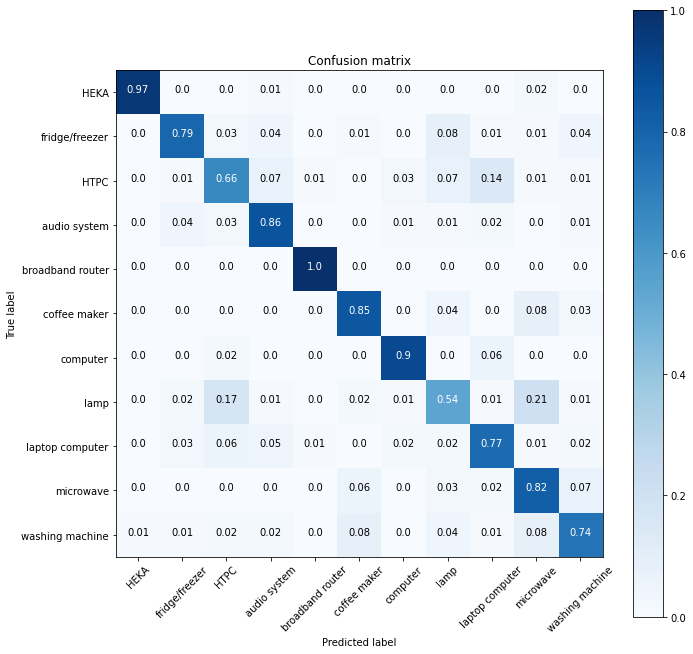

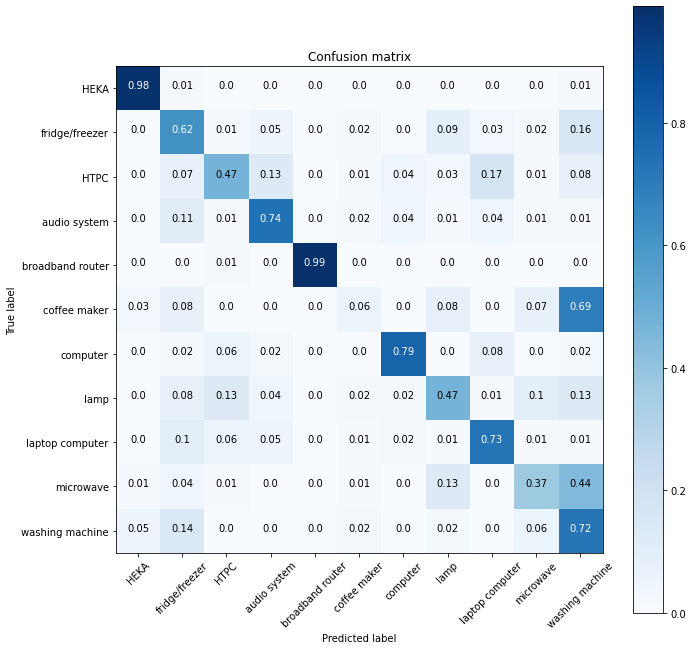

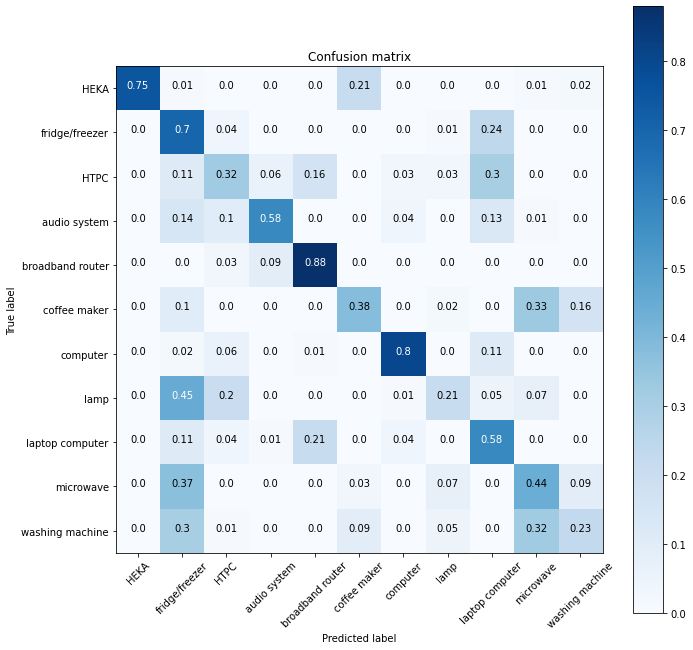

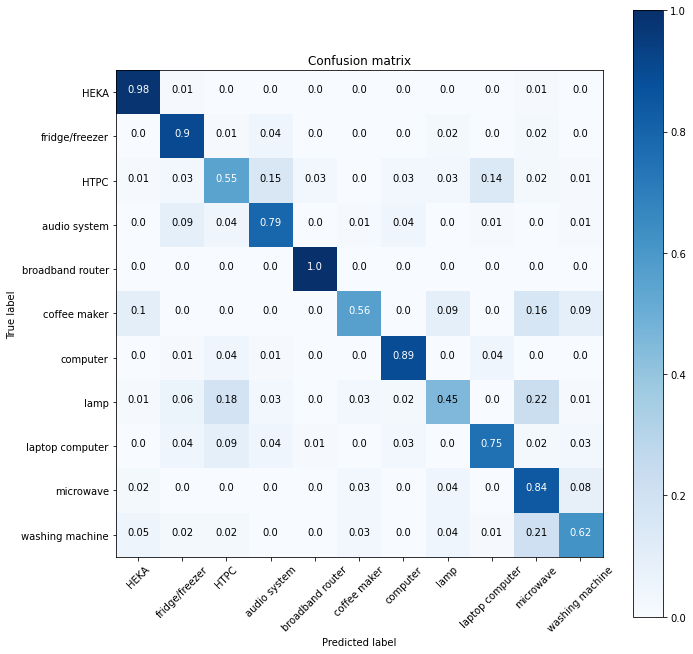

In [15]:
# datasets =[
#     "ukdale_gen_GASF_13m_100S5X12A54480_R82_80-20"
# ]

if environ['train_type'] == "TL": 
    models = environ['tl_datasets'].replace(" ","").split(",")
    #model = ["base"]
    
    for model in models:
    
        file_name = dataset
        
        datasetTL = model
        
        seed = dataset.split("_R")[1][0:2]
        
        print("using dataset data",dataset.split("_")[0],"training on model",model,"seed",environ['seed'])
        txt_log.write("starting "+dataset.split("_")[0]+" training on model "+model+" seed "+environ['seed']+"\n")


        tf.keras.backend.clear_session()


        #read the file
        path = str(pathlib.Path().resolve())
        path_data = f"{path}""/data/"f"{file_name}""/"f"{file_name}"".hdf5"
        file = h5py.File(path_data,"r+")


        print("reading data, printing stats: ")
        x_test,y_test,d_class_weights,num_of_classes,appliances = get_data(file)
        print("loading model")
        
        model_seed = 42
        model_used = create_tl_model(model,environ['learn_type'],model_seed,path,num_of_classes)
                
        train_gen = HDF5ImageGenerator(
            src= path_data,
            X_key="data/train/gaf",
            y_key="labels/train/gaf",
            classes_key="appliances/classes",
            labels_encoding="hot",
            shuffle=True,
            batch_size=int(environ['batch_size']),
            num_classes=num_of_classes,
            mode="train",
            )

        model_used.fit(
            train_gen,
            verbose=2,
            epochs=int(environ['epochs']),
            class_weight=d_class_weights,
            callbacks = [save_op_callback]
            #workers = 6,
        )
        
        txt_log.write("finished "+dataset.split("_")[0]+" training on model "+model+" seed "+environ['seed']+"\n")


        evaluate_model(model_used,x_test,y_test,appliances)
        



        #del model_used



In [16]:
txt_log.close()